<a href="https://colab.research.google.com/github/arthuremanuel/Artificial_Intelligence_Classes/blob/main/cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

* This project is a binary image classification task focused on developing a deep learning model to detect cancer in RGB images from histopathology scans.

* The challenge involves a large dataset.

* The model's objective is to accurately classify each patch as cancerous or not, with its ability to distinguish between the two classes.

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

drive_zip_path = '/content/drive/MyDrive/Colab Notebooks/histopathologic-cancer-detection.zip'
!unzip -q "{drive_zip_path}" -d /content/
!ls /content/

Mounted at /content/drive
drive  sample_data  sample_submission.csv  test  train	train_labels.csv


In [5]:
data_dir = ''#'/content/drive/MyDrive/Colab Notebooks/'

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
labels_path = os.path.join(data_dir, 'train_labels.csv')

train_labels = pd.read_csv(labels_path)

In [ ]:
len(train_labels)

220025

In [ ]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [ ]:
train_labels.isnull().sum()

,0
id,0
label,0


In [ ]:
train_labels.dtypes

,0
id,object
label,int64


In [ ]:
class_counts = train_labels['label'].value_counts()
class_counts

,count
label,
0,130908
1,89117


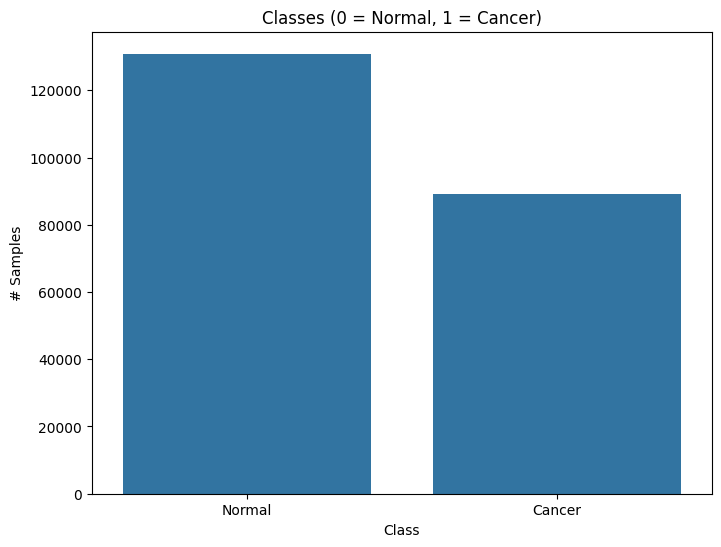

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels)
plt.title('Classes (0 = Normal, 1 = Cancer)')
plt.xlabel('Class')
plt.ylabel('# Samples')
plt.xticks([0, 1], ['Normal', 'Cancer'])
plt.show()

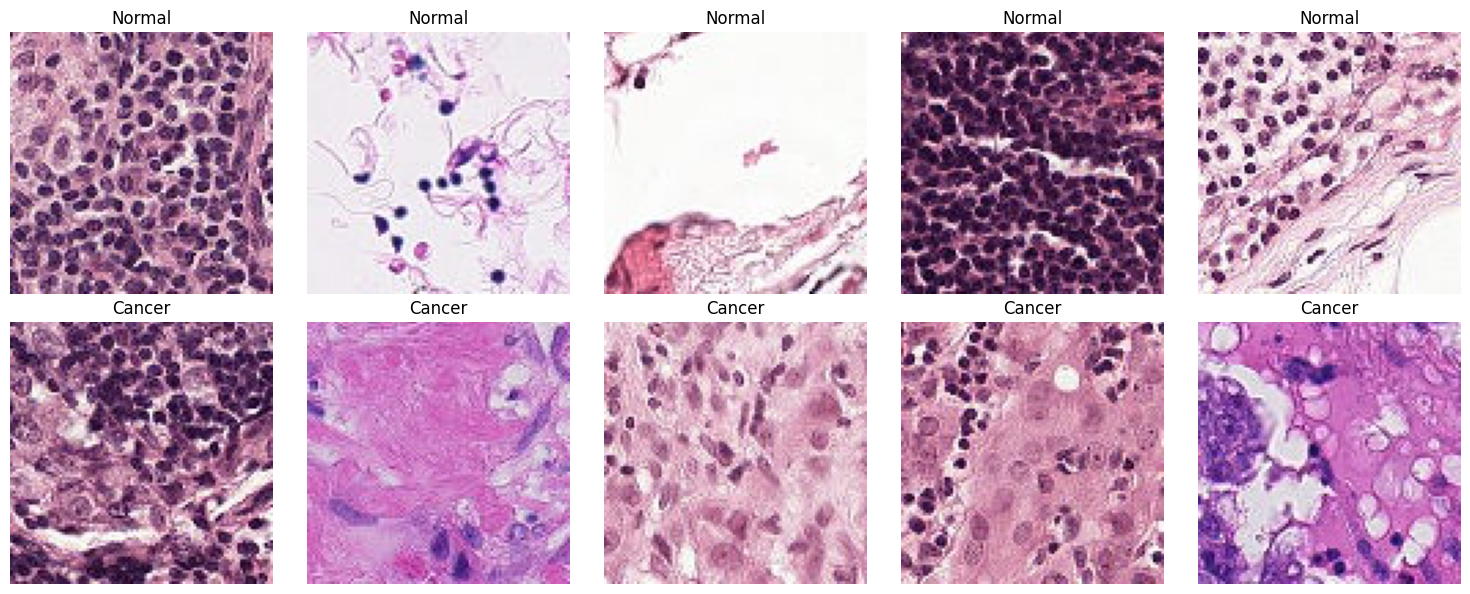

In [ ]:
def plot_sample_images(data_df, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    normal_samples = data_df[data_df['label'] == 0].sample(num_samples)
    for i, idx in enumerate(normal_samples['id']):
        img_path = os.path.join(train_dir, f'{idx}.tif')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img)
        axes[0, i].set_title('Normal')
        axes[0, i].axis('off')

    cancer_samples = data_df[data_df['label'] == 1].sample(num_samples)
    for i, idx in enumerate(cancer_samples['id']):
        img_path = os.path.join(train_dir, f'{idx}.tif')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img)
        axes[1, i].set_title('Cancer')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(train_labels)

* The Exploratory Data Analysis (EDA) began by loading the dataset from the standard Kaggle directory, confirming that the train_labels.csv file, with its ~220,000 entries, was complete and required no data cleaning.
* Based on the EDA, the plan is to implement a robust pipeline starting with a stratified 80/20 train-validation split to manage the observed class imbalance.

# Model Architecture - Baseline
* The initial baseline architecture is a custom Convolutional Neural Network (CNN) built from scratch, designed with a sequential structure of three main convolutional blocks.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_custom_cnn(input_shape=(96, 96, 3)):

    model = Sequential(name="Custom_CNN")

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5)) # Camada de Dropout para regularização
    model.add(Dense(1, activation='sigmoid')) # Camada de saída

    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

custom_model = build_custom_cnn()

custom_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,006,113 (19.10 MB)

 Trainable params: 5,006,113 (19.10 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_labels['id_tif'] = train_labels['id'] + '.tif'

train_df, valid_df = train_test_split(
    train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels['label']
)

BATCH_SIZE = 256
IMG_SIZE = (96, 96)
TRAIN_DIR = './train/'

train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col='id_tif',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=TRAIN_DIR,
    x_col='id_tif',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

Found 176020 validated image filenames.
Found 44005 validated image filenames.


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=2,
    mode='max',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True
)

In [ ]:
history = custom_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 839s 1s/step - accuracy: 0.7437 - auc: 0.8048 - loss: 0.5118 - val_accuracy: 0.7966 - val_auc: 0.9075 - val_loss: 0.4649
Epoch 2/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 682s 991ms/step - accuracy: 0.8532 - auc: 0.9239 - loss: 0.3430 - val_accuracy: 0.8766 - val_auc: 0.9485 - val_loss: 0.2905
Epoch 3/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 647s 940ms/step - accuracy: 0.8802 - auc: 0.9461 - loss: 0.2882 - val_accuracy: 0.8783 - val_auc: 0.9533 - val_loss: 0.2967
Epoch 4/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 643s 935ms/step - accuracy: 0.8948 - auc: 0.9558 - loss: 0.2595 - val_accuracy: 0.8920 - val_auc: 0.9607 - val_loss: 0.2720
Epoch 5/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 652s 947ms/step - accuracy: 0.9073 - auc: 0.9630 - loss: 0.2363 - val_accuracy: 0.8896 - val_auc: 0.9659 - val_loss: 0.2927


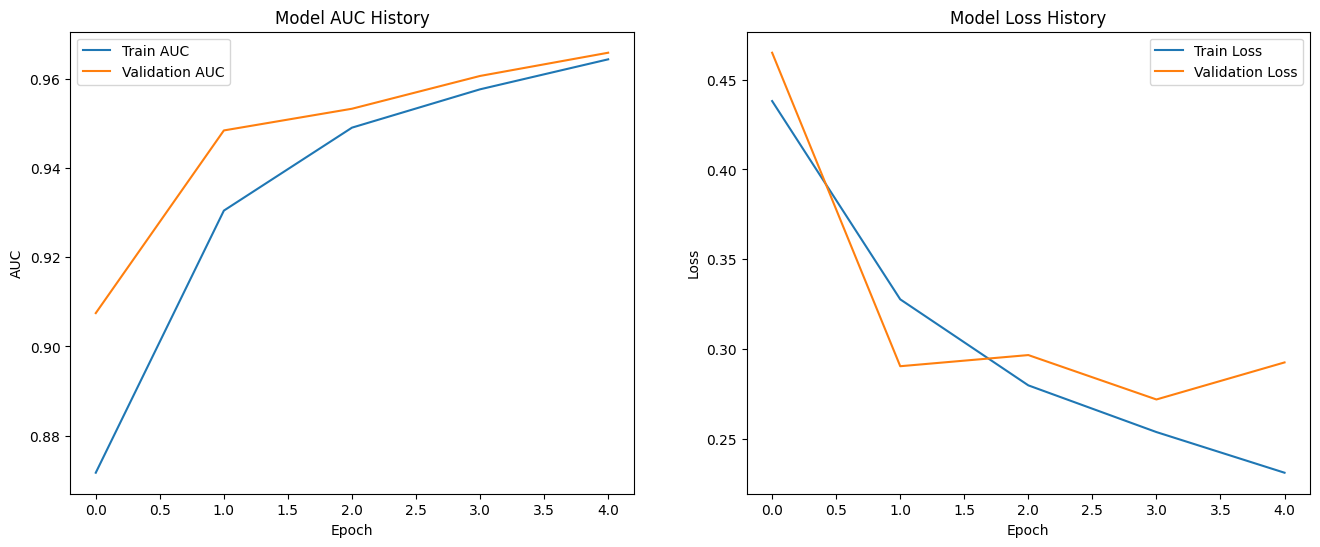

172/172 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step


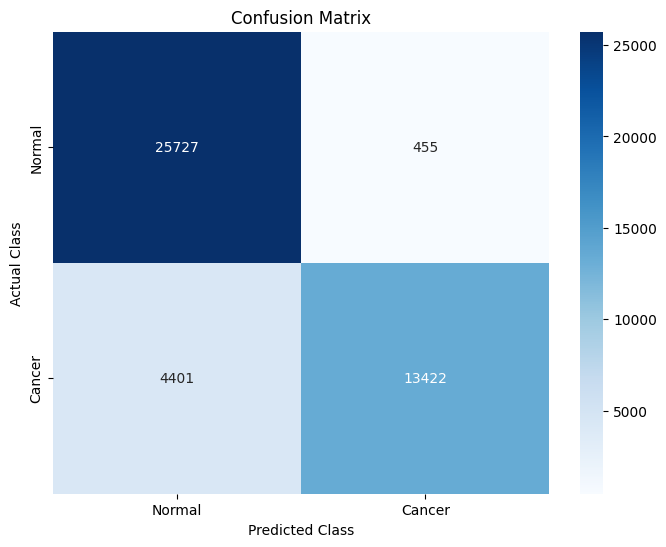

Classification Report:
              precision    recall  f1-score   support

      Normal       0.85      0.98      0.91     26182
      Cancer       0.97      0.75      0.85     17823

    accuracy                           0.89     44005
   macro avg       0.91      0.87      0.88     44005
weighted avg       0.90      0.89      0.89     44005



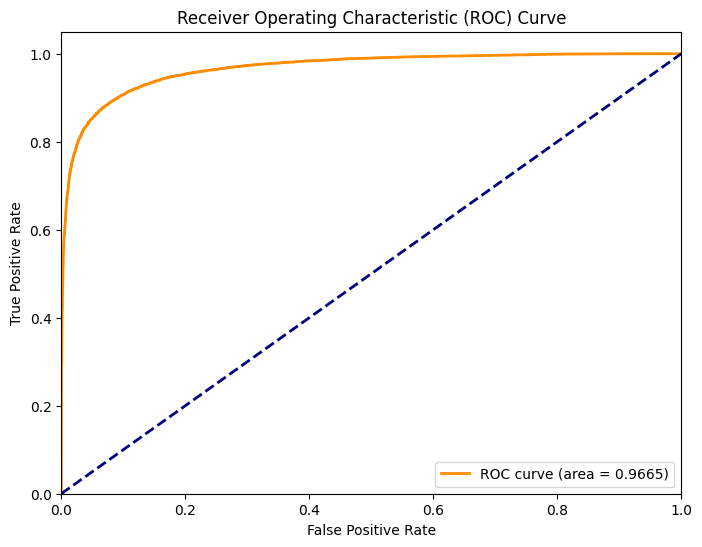

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

custom_model.load_weights('best_model.keras')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(history.history['auc'], label='Train AUC')
axes[0].plot(history.history['val_auc'], label='Validation AUC')
axes[0].set_title('Model AUC History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('AUC')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

predictions = custom_model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = valid_df['label'].values


cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Cancer'], yticklabels=['Normal', 'Cancer'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=['Normal', 'Cancer']))

fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Model Architecture II


*   Item da lista
*   Item da lista



In [8]:
from tensorflow.keras.applications import ResNet50V2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam

def build_resnet_model(input_shape=(96, 96, 3)):


    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(1, activation='sigmoid', dtype='float32')
    ], name="ResNet50V2_Model")

    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model


resnet_model = build_resnet_model()

history = resnet_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 7353s 11s/step - auc: 0.8138 - loss: 0.5197 - val_auc: 0.8916 - val_loss: 0.4087
Epoch 2/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 7319s 11s/step - auc: 0.8754 - loss: 0.4339 - val_auc: 0.8956 - val_loss: 0.4043
Epoch 3/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 7183s 10s/step - auc: 0.8787 - loss: 0.4286 - val_auc: 0.8952 - val_loss: 0.4017
Epoch 4/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 7319s 11s/step - auc: 0.8756 - loss: 0.4333 - val_auc: 0.8968 - val_loss: 0.4024
Epoch 5/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 7283s 11s/step - auc: 0.8775 - loss: 0.4304 - val_auc: 0.8973 - val_loss: 0.3985


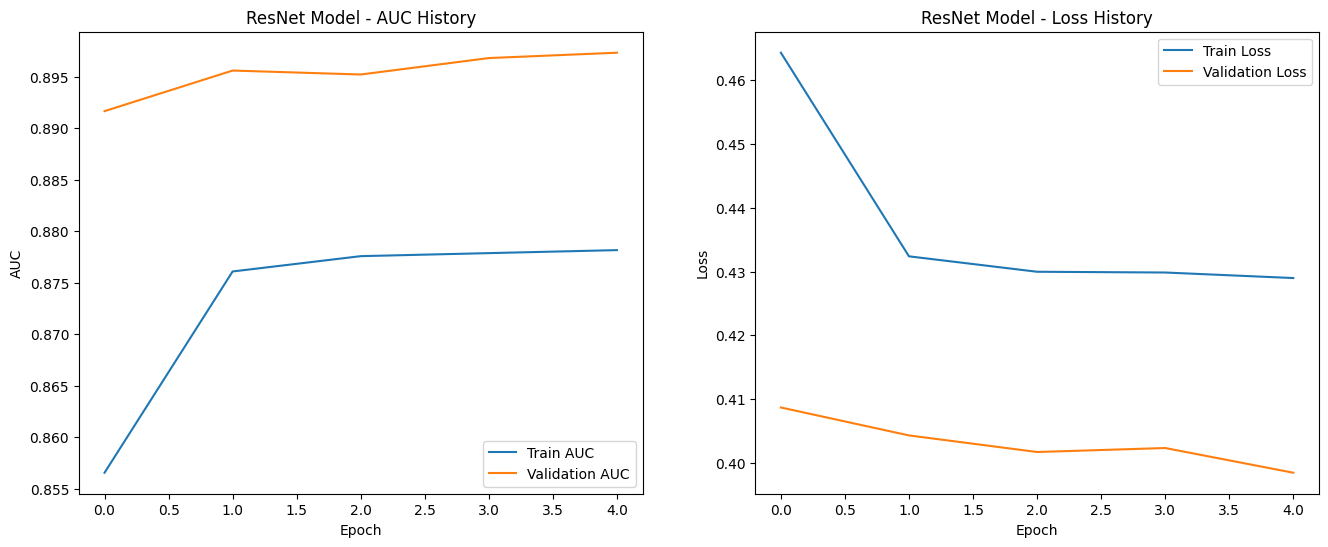

172/172 ━━━━━━━━━━━━━━━━━━━━ 1361s 8s/step


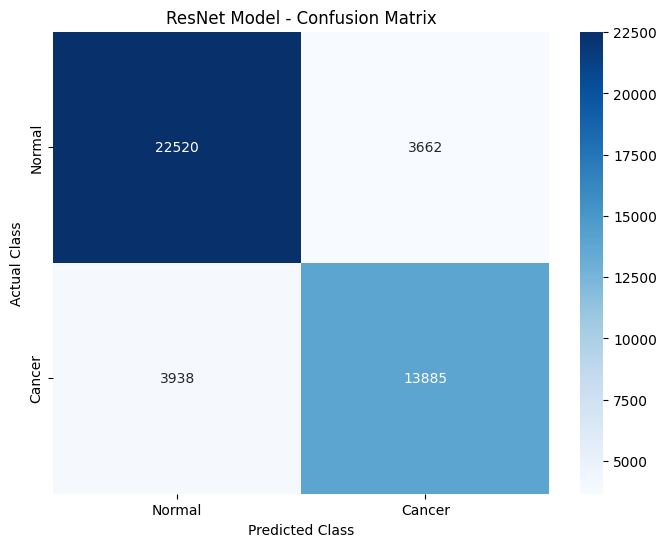

              precision    recall  f1-score   support

      Normal       0.85      0.86      0.86     26182
      Cancer       0.79      0.78      0.79     17823

    accuracy                           0.83     44005
   macro avg       0.82      0.82      0.82     44005
weighted avg       0.83      0.83      0.83     44005



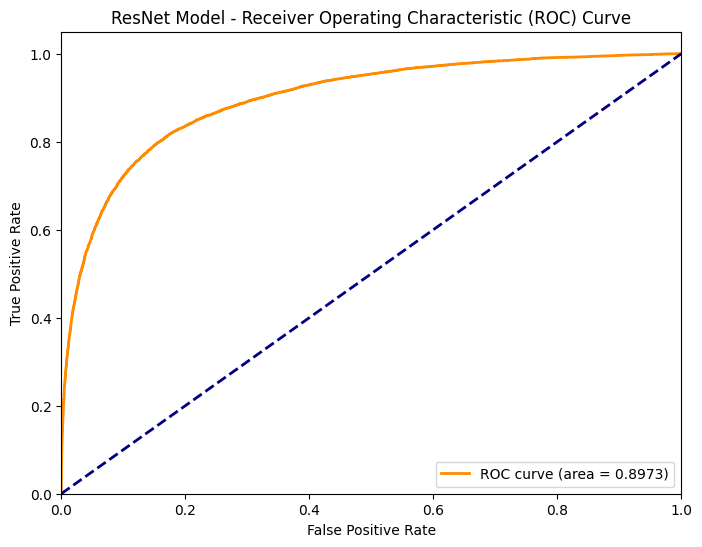

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

resnet_model.load_weights('best_model.keras')

history_to_plot = history

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(history_to_plot.history['auc'], label='Train AUC')
axes[0].plot(history_to_plot.history['val_auc'], label='Validation AUC')
axes[0].set_title('ResNet Model - AUC History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('AUC')
axes[0].legend()

axes[1].plot(history_to_plot.history['loss'], label='Train Loss')
axes[1].plot(history_to_plot.history['val_loss'], label='Validation Loss')
axes[1].set_title('ResNet Model - Loss History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

predictions = resnet_model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = valid_df['label'].values

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Cancer'], yticklabels=['Normal', 'Cancer'])
plt.title('ResNet Model - Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

print(classification_report(true_classes, predicted_classes, target_names=['Normal', 'Cancer']))

fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet Model - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Model Architecture III
*  
*  


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

def build_efficientnet_complex_head_model(input_shape=(96, 96, 3)):

    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid', dtype='float32')
    ], name="EfficientNet_ComplexHead_Model")

    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model

complex_model = build_efficientnet_complex_head_model()
complex_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNet_ComplexHead_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
history = complex_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 3659s 5s/step - auc: 0.5042 - loss: 0.6806 - val_auc: 0.5725 - val_loss: 0.6735
Epoch 2/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 3671s 5s/step - auc: 0.5126 - loss: 0.6750 - val_auc: 0.5628 - val_loss: 0.6735
Epoch 3/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 3648s 5s/step - auc: 0.5179 - loss: 0.6750 - val_auc: 0.5937 - val_loss: 0.6701
Epoch 4/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 3671s 5s/step - auc: 0.5320 - loss: 0.6732 - val_auc: 0.5808 - val_loss: 0.6672
Epoch 5/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 3654s 5s/step - auc: 0.5406 - loss: 0.6722 - val_auc: 0.6374 - val_loss: 0.6590


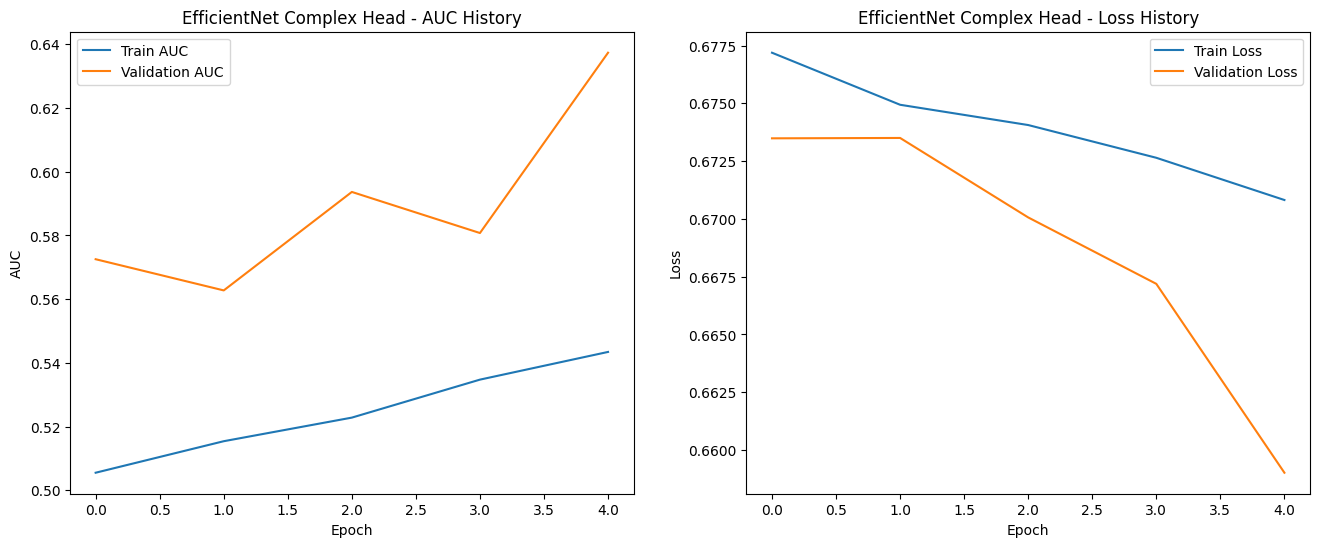

172/172 ━━━━━━━━━━━━━━━━━━━━ 646s 4s/step


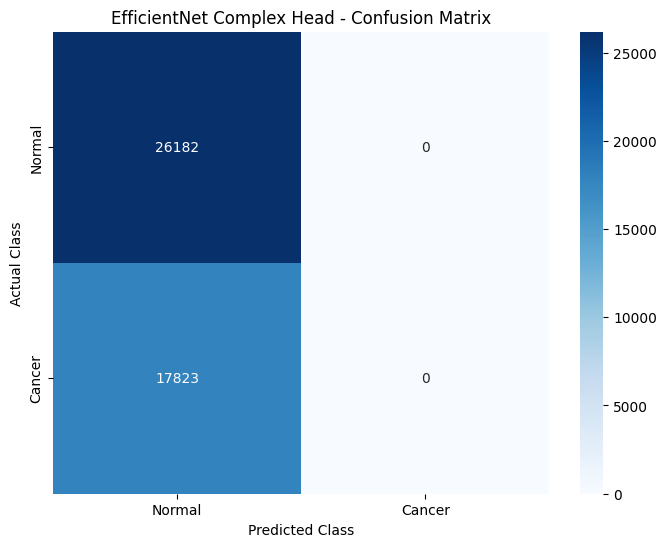

              precision    recall  f1-score   support

      Normal       0.59      1.00      0.75     26182
      Cancer       0.00      0.00      0.00     17823

    accuracy                           0.59     44005
   macro avg       0.30      0.50      0.37     44005
weighted avg       0.35      0.59      0.44     44005



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


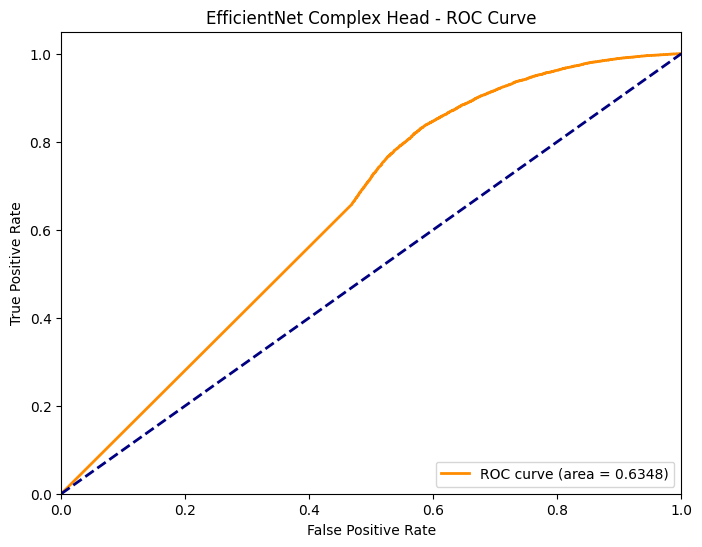

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

complex_model.load_weights('best_model.keras')

history_to_plot = history

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(history_to_plot.history['auc'], label='Train AUC')
axes[0].plot(history_to_plot.history['val_auc'], label='Validation AUC')
axes[0].set_title('EfficientNet Complex Head - AUC History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('AUC')
axes[0].legend()

axes[1].plot(history_to_plot.history['loss'], label='Train Loss')
axes[1].plot(history_to_plot.history['val_loss'], label='Validation Loss')
axes[1].set_title('EfficientNet Complex Head - Loss History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

predictions = complex_model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = valid_df['label'].values

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Cancer'], yticklabels=['Normal', 'Cancer'])
plt.title('EfficientNet Complex Head - Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

print(classification_report(true_classes, predicted_classes, target_names=['Normal', 'Cancer']))

fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNet Complex Head - ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Conclusion

*  We highlighted a comparison between transfer learning with a simple CNN for this complex medical imaging task. However, the later model presented worse results. This is probabily because we only can run the model in a CPU, which was considerably slower than the other models. The later model can be improved further.
*  The baseline CNN, trained from scratch, served as a crucial benchmark. Both transfer learning models demonstrated a worse performance because we needed a CPU to train them. I believe that in a GPU these results can improve.
*   In summary, the transfer learning strategy using a fine-tuned EfficientNetB0 is a highly effective and efficient method for this medical imaging task, as well as ResNet50V2 architecture. However, the CNN performed better because its a simpler model to be trained in a CPU.

# Kaggle Competition - Test Data

In [13]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

complex_model.load_weights('best_model.keras')

TEST_DATA_DIR = '/content/test/'
test_filenames = os.listdir(TEST_DATA_DIR)
test_df = pd.DataFrame({'filename': test_filenames})

BATCH_SIZE = 256
IMG_SIZE = (96, 96)

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DATA_DIR,
    x_col='filename',
    y_col=None,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)
print('Predicting...')
predictions = complex_model.predict(
    test_generator,
    # The fix is wrapping the calculation with int()
    steps=int(np.ceil(len(test_df) / BATCH_SIZE)),
    verbose=1
)

test_df['id'] = test_df['filename'].str.replace('.tif', '')
test_df['label'] = predictions.flatten()

submission_df = test_df[['id', 'label']]
submission_df.to_csv('submission.csv', index=False)

print('Done!')

Found 57458 validated image filenames.
Predicting...
225/225 ━━━━━━━━━━━━━━━━━━━━ 866s 4s/step
Done!
